<a href="https://colab.research.google.com/github/Saleem146/ProjetSpark/blob/main/Projet_Spark_Prevision_trafic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-projet Apache Spark

Merci d'indiquer les noms composant le binôme :

|Nom | Prénom|
|---|---|
| DJIMA | Saleem |
| ILBOUDO | Ben |

L'objectif est de collecter les données de validations quotidiennes de titres de transport de la région parisienne, disponibles en Open Data sur le site de Mobilités Ile-de-France.

On se concentrera sur le **réseau ferré** exclusivement pour cet exercice.

## Installation de Spark

Apache Spark n'est pas disponible en standard sur Google Colab.
Procéder à son installation, ainsi qu'à son initialisation pour réaliser le traitement à venir.

In [ ]:
# installation et initialistion de spark
!pip install pyspark

import pyspark

spark = pyspark.sql.SparkSession.builder.appName("Projet").getOrCreate()


## Récupération des données

Sur le site https://data.iledefrance-mobilites.fr, récupérer les données de validation par jour.

Exemple :
https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/information/

Récupérer les données de S1 2020 et S2 2021 pour disposer d'une année complète.

On utilisera pour ce faire les commandes de téléchargement de fichiers depuis un site (pas de chargement manuel).

__Attention__ : prévoir une vingtaine de minutes pour le téléchargement, au moins une première fois, et donc une copie sur Google Drive si Google Colab est utilisée, afin d'éviter ce temps d'attente lors de sessions de travail successives.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Vos instructions pour le téléchargement
# premier semestre 2021
!curl -o s12021.csv https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B 
# second semestre 2020
!curl -o s22020.csv https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M    0 24.7M    0     0   132k      0 --:--:--  0:03:10 --:--:--  190k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.3M    0 47.3M    0     0   199k      0 --:--:--  0:04:02 --:--:--  222k


### Commentaires sur les données disponibles sur ce portail

Investiguer les données diponibles sur le portail.

Question : peut-on constituer un historique de données s'étendant sur les trois dernières années (2019 à 2021) ?


Non on ne peut pas constituer un historique de données sur les trois dernières années. En effet, les données disponibles sur ses périodes ne sont pas disponible.

## Lecture des fichiers dans Spark

Lire les fichiers en choisissant les bonnes options de lecture.
Concaténer les données en une seule table.

In [ ]:
# Lecture des fichiers dans Spark
import pyspark.sql.functions as fun

s12021_ddf = (spark
              .read 
              .csv("/content/s12021.csv",sep=";",header = True,inferSchema= True)
              )

s22020_ddf = (spark
              .read 
              .csv("/content/s22020.csv",sep=";",header = True,inferSchema= True)
              )

In [ ]:
# regarder la liste des fichiers
s12021_ddf.show(5)
s22020_ddf.show(5)

+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|libelle_arret|id_refa_lda|categorie_titre|nb_vald|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|2021-01-04|           100|          110|             47|       BALARD|      71073|              ?|    110|
|2021-01-04|           100|          110|             47|       BALARD|      71073|    NAVIGO JOUR|      7|
|2021-01-04|           100|          110|            476|  LOUIS BLANC|      71407|              ?|     24|
|2021-01-04|           100|          110|            476|  LOUIS BLANC|      71407|    AUTRE TITRE|    132|
|2021-01-04|           100|          110|            478|LOUISE MICHEL|      73667|            TST|    226|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
only showing top 5 rows

+--

In [ ]:
# Votre code
# concatener les dataframes

validations_ddf = s22020_ddf.union(s12021_ddf)

## Validation

Si vous avez appelé votre dataframe `validations_ddf`, le test suivant ne doit pas générer d'erreur.

In [ ]:
assert validations_ddf.count() == 1_316_287, "Le nombre de lignes ne correspond pas"

Dans le cas où ce code génère une erreur, il s'agit probablement d'un problème de récupération ou de lecture des deux fichiers.

## Préparation des données

Réaliser les transformations nécessaires pour exploiter ces données :
- préparation des dates
- transformation du nombre de validation

### Explication pour le nombre de validations

Analyser les valeurs prises par ce champ et déterminer le problème.
Présenter votre stratégie pour remédier à ce choix de codage par Mobilités Ile-de-France.

In [ ]:
# code pour voir les columns et leurs types
validations_ddf.printSchema()
# on peut voir que la 8ième colonne (nb_vald) est de type string alors qu'elle contient majoritairemeent des nbres
# En effet, on a ce problème parce que pour certaines valeurs on a des chaines de caractère comme:
# moins de 5



root
 |-- jour: string (nullable = true)
 |-- code_stif_trns: integer (nullable = true)
 |-- code_stif_res: string (nullable = true)
 |-- code_stif_arret: string (nullable = true)
 |-- libelle_arret: string (nullable = true)
 |-- id_refa_lda: string (nullable = true)
 |-- categorie_titre: string (nullable = true)
 |-- nb_vald: string (nullable = true)



In [ ]:
validations_ddf.agg({'nb_vald':'max'}).show()

+------------+
|max(nb_vald)|
+------------+
|  Moins de 5|
+------------+



On remarque qu' au niveau de la colonne correspondant au "nombre de validation", il y a une modalité "Moins de 5". Pour résoudre ce problème, nous avons pris la médiane de l'intervalle entre 1 et 4 qui est 2. 
REMARQUE: On remarque que les pass navigo sont subdivisés en pass Navigo et pass Navigo Jour. Afin d'avoir une seule catégorie de pass Navigo nous avons transformé les pass Navigos jour en pass Navigo. 

In [ ]:
# On essaie de remplacer les moins de 5 par 2
validations_ddf2 = validations_ddf.withColumn('nb_vald', fun.regexp_replace('nb_vald', 'Moins de 5', '2')).withColumn("categorie_titre",fun.regexp_replace("categorie_titre","NAVIGO JOUR", "NAVIGO"))

In [ ]:
# On va donc changer le type de cette colonne en numeric tout en supprimant les strings et en précisant que la variable jour est une date
validations_ddf2 = validations_ddf2.withColumn("nb_vald",validations_ddf2["nb_vald"].cast('Integer')).withColumn('jour', fun.to_date(fun.col('jour')))
# Comme on peut le voir ci-dessous les types de nb_vald sont biens integers 

In [ ]:
# On vérifie les types de nos variables
validations_ddf2.printSchema()

root
 |-- jour: date (nullable = true)
 |-- code_stif_trns: integer (nullable = true)
 |-- code_stif_res: string (nullable = true)
 |-- code_stif_arret: string (nullable = true)
 |-- libelle_arret: string (nullable = true)
 |-- id_refa_lda: string (nullable = true)
 |-- categorie_titre: string (nullable = true)
 |-- nb_vald: integer (nullable = true)



## Détermination des principales catégories de titre

Différentes catégories de titre sont utilisées sur le réseau.

Déterminer les deux catégories principalement utilisées. Seules ces catégories seront utilisées dans les travaux ci-après (les utiliser comme filtre sur les validations dans la suite).

In [ ]:
# Pass les plus utilisés:
validations_ddf2.groupBy('categorie_titre').count().sort('count',ascending=False).show()

+---------------+------+
|categorie_titre| count|
+---------------+------+
|         NAVIGO|279802|
|      IMAGINE R|160057|
|            FGT|157210|
|            TST|156707|
|      AMETHYSTE|154723|
|     NON DEFINI|151096|
|              ?|140873|
|    AUTRE TITRE|115819|
+---------------+------+



On remarque que les deux catégories de pass les plus utilisés sont le pass Navigo et le pass Imagine R

## Visualisation du trafic dans une station

Visualiser le trafic à la gare de Lyon pour les deux catégories de titre principales.

Attention à gérer le cas des gares (comme la gare de Lyon) présentes sur plusieurs lignes et dont le libellé apparaît donc sur plusieurs lignes. Investiguer ce cas avant de déterminer la bonne façon de calculer le nombre de validations pour la gare de Lyon.

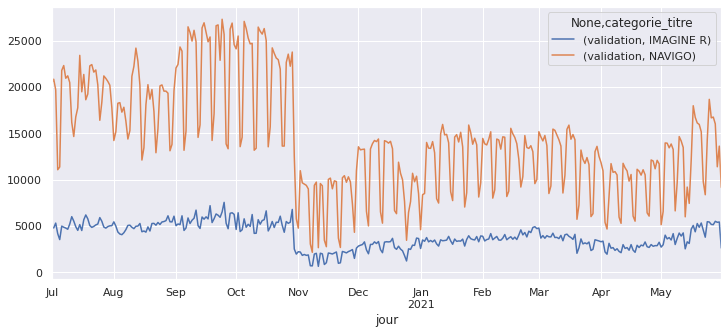

In [ ]:
import seaborn as sns
sns.set()

(validations_ddf2
 .filter(validations_ddf2.libelle_arret =="GARE DE LYON")
 .where((validations_ddf2.categorie_titre == "NAVIGO" ) | (validations_ddf2.categorie_titre == "IMAGINE R"))
 .groupBy(['jour', 'categorie_titre'])
 .agg(fun.sum('nb_vald').alias('validation'))
 .orderBy(['jour', 'categorie_titre'])
).toPandas().set_index([ 'jour','categorie_titre']).unstack(1).plot(figsize=(12, 5));

## Fluctuation du trafic hebdomadaire

Calculer le trafic total et le pourcentage par jour de la semaine sur l'ensemble du réseau.

Trier le résultat par ordre décroissant de validations.

Note : considérer l'usage d'une fonction analytique (`Window.partitionBy()`).


In [ ]:
import pyspark.sql.functions as F

from pyspark.sql.window import Window
(validations_ddf2
 .select('jour', 'libelle_arret', 'categorie_titre', 'nb_vald')
 #.filter(validations_ddf2.libelle_arret =="GARE DE LYON")
 .where((validations_ddf2.categorie_titre == "NAVIGO" ) | (validations_ddf2.categorie_titre == "IMAGINE R"))
 .withColumn('trafic_total',F.sum(F.col('nb_vald')).over(Window.partitionBy(F.weekofyear(F.col('jour')))))
 .withColumn('pourcentage_journalier',F.sum(F.col('nb_vald')).over(Window.partitionBy(F.weekofyear(F.col('jour')),F.dayofweek(F.col('jour'))))/(F.sum(F.col('nb_vald')).over(Window.partitionBy(F.weekofyear(F.col('jour'))))))
 .orderBy(["jour"], ascending = True)
).show(5)


+----------+--------------------+---------------+-------+------------+----------------------+
|      jour|       libelle_arret|categorie_titre|nb_vald|trafic_total|pourcentage_journalier|
+----------+--------------------+---------------+-------+------------+----------------------+
|2020-07-01|       PORTE MAILLOT|         NAVIGO|   7244|     9106908|   0.24223995674492374|
|2020-07-01|              BOURSE|      IMAGINE R|    531|     9106908|   0.24223995674492374|
|2020-07-01|              ALESIA|      IMAGINE R|   1230|     9106908|   0.24223995674492374|
|2020-07-01|              ALESIA|         NAVIGO|   4067|     9106908|   0.24223995674492374|
|2020-07-01|BOULOGNE-PONT DE ...|      IMAGINE R|    638|     9106908|   0.24223995674492374|
+----------+--------------------+---------------+-------+------------+----------------------+
only showing top 5 rows



## Analyse de l'impact du reconfinement d'octobre 2020

Mettre en évidence graphiquement l'impact du reconfinement.

N'utiliser que les catégories de titre _IMAGINE R_ et _Navigo_.


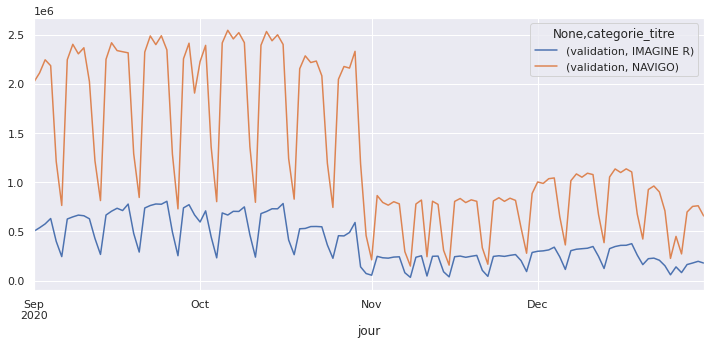

In [ ]:
# On a représenté le trafici sur les mois de septembre, octobre, novembre et décembre


validations_ddf3 = validations_ddf2.where((validations_ddf2.categorie_titre == "NAVIGO" ) | (validations_ddf2.categorie_titre == "IMAGINE R"))
validations_ddf6 = validations_ddf3.withColumn('mois', F.month(F.col('jour')))
validations_ddf7 = validations_ddf6.where((validations_ddf6.mois == 10) | (validations_ddf6.mois == 11)| (validations_ddf6.mois == 9) | (validations_ddf6.mois == 12))

(validations_ddf7
 #.filter(validations_ddf7.libelle_arret =="GARE DE LYON")
 .where((validations_ddf7.categorie_titre == "NAVIGO" ) | (validations_ddf7.categorie_titre == "IMAGINE R"))
 .withColumn('jour', F.date_trunc('day', F.col('jour')))
 .groupBy(['jour', 'categorie_titre'])
 .agg(F.sum('nb_vald').alias('validation'))
 .orderBy(['jour', 'categorie_titre'])
).toPandas().set_index([ 'jour','categorie_titre']).unstack(1).plot(figsize=(12, 5));


On remarque une grande baisse du trafic à partir de la fin du mois d'octobre qui marque l'effet du confinement .


#### Bonus

Calculer la moyenne glissante sur 7 jours par categorie de titre pour réduire les variations hebdomadaires.

In [ ]:
# On a extraire les différentes semaines de l'années et utilisé la commande windows partition pour pouvoir calculer la moyenne glissante sur 7 jours.
validations_ddf5 = validations_ddf3.withColumn('semaine', F.weekofyear(F.col('jour')))
dff = validations_ddf5.withColumn('rolling_average', F.avg("nb_vald").over(Window.partitionBy(F.col("categorie_titre"),F.window("jour", "7 days"))))


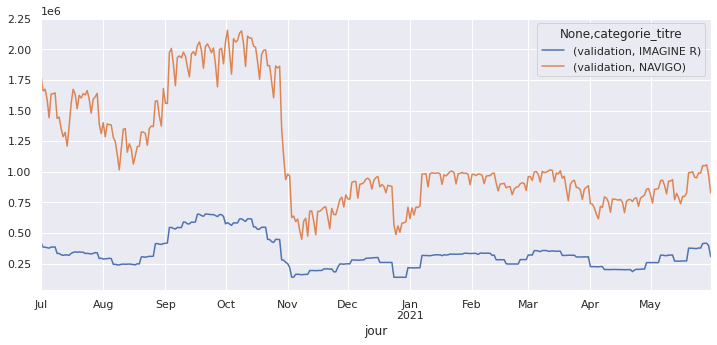

In [ ]:
(dff
 #.filter(dff.libelle_arret =="GARE DE LYON")
 .where((dff.categorie_titre == "NAVIGO" ) | (dff.categorie_titre == "IMAGINE R"))
 .withColumn('jour', F.date_trunc('day', F.col('jour')))
 .groupBy(['jour', 'categorie_titre'])
 .agg(F.sum('rolling_average').alias('validation'))
 .orderBy(['jour', 'categorie_titre'])
).toPandas().set_index([ 'jour','categorie_titre']).unstack(1).plot(figsize=(12, 5))


Le graphique ci-dessus montre la réduction des fluctuations des catégories Navigo et Imagine R en utilisant les moyennes glissantes sur 7 jours. 

## Modélisation avec Apache Spark

On essaie de faire un modèle basique de prévision du trafic dans les 7 prochains jours, pour une station.

Apache Spark MLlib n'intègre pas de modèle pour les séries chronologiques.

L'approche classique est alors d'utiliser une technique de régression classique (régression linéaire bien sûr, mais aussi RandomForestRegressor par exemple).

Pour une première version simple, utiliser un vecteur constituer des validations sur les 14 jours précédents (X) pour prédire les validations du jour (y). Dans cette version, on utilisera une `LinearRegression` ou un `RandomForestRegressor`, au choix.

Le code doit comporter :
- la préparation des _features_ (X)
- la constitution d'un ensemble d'apprentissage et de test
- l'entrainement d'un modèle
- le mesure de la performance du modèle : RMSE

Rappel : ne travailler que sur les deux catégories de titre principales.


**Preparation de features(X)**

**Dans la suite nous avons choisi la Gare de LYON comme Station**

In [ ]:
# On va convertir notre base en une base de machine learning tout en ordonnant les dates
# Convertion en base pandas
# On prend uniquement les catégories Navigo et Imagine R
df = (validations_ddf3
 #.filter(~fun.isnull(fun.col("nb_vald")))
 .filter(validations_ddf2.libelle_arret =="GARE DE LYON")
 .where((validations_ddf2.categorie_titre =="NAVIGO") | (validations_ddf2.categorie_titre =="IMAGINE R"))
 .withColumn("journée", fun.date_trunc("day", fun.col("jour")))
 .groupBy(["journée"])
 .agg(fun.sum("nb_vald").alias("validation total"))
 .orderBy("journée")
 ).toPandas().set_index(["journée"])

In [ ]:
from statsmodels.tsa.tsatools import lagmat

import pandas as pd

lag = 14
X = lagmat(df["validation total"], lag)
lagged = df.copy()
for c in range(1, lag +1):
  lagged["lag%d" % c] = X[:, c-1]

pd.concat([lagged.head(),lagged.tail()]) 

,validation total,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
journée,,,,,,,,,,,,,,,
2020-07-01,25309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-02,25618,25309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03,24999,25618.0,25309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-04,15237,24999.0,25618.0,25309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-05,14893,15237.0,24999.0,25618.0,25309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-27,21887,21830.0,24088.0,19768.0,12157.0,14343.0,20480.0,20808.0,21375.0,21088.0,23026.0,16819.0,10548.0,12484.0,8517.0
2021-05-28,21514,21887.0,21830.0,24088.0,19768.0,12157.0,14343.0,20480.0,20808.0,21375.0,21088.0,23026.0,16819.0,10548.0,12484.0
2021-05-29,16780,21514.0,21887.0,21830.0,24088.0,19768.0,12157.0,14343.0,20480.0,20808.0,21375.0,21088.0,23026.0,16819.0,10548.0
2021-05-30,19040,16780.0,21514.0,21887.0,21830.0,24088.0,19768.0,12157.0,14343.0,20480.0,20808.0,21375.0,21088.0,23026.0,16819.0


In [ ]:
# On transforme notre base pandas en base spark (ddf) pour pouvoir travailler sur pyspark
ddf = spark.createDataFrame(lagged.reset_index(drop=False))

In [ ]:
ddf.printSchema()

root
 |-- journée: timestamp (nullable = true)
 |-- validation total: long (nullable = true)
 |-- lag1: double (nullable = true)
 |-- lag2: double (nullable = true)
 |-- lag3: double (nullable = true)
 |-- lag4: double (nullable = true)
 |-- lag5: double (nullable = true)
 |-- lag6: double (nullable = true)
 |-- lag7: double (nullable = true)
 |-- lag8: double (nullable = true)
 |-- lag9: double (nullable = true)
 |-- lag10: double (nullable = true)
 |-- lag11: double (nullable = true)
 |-- lag12: double (nullable = true)
 |-- lag13: double (nullable = true)
 |-- lag14: double (nullable = true)



In [ ]:
from pyspark.sql import Window
from pyspark.ml.linalg import Vector
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols= ['lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag8','lag9','lag10','lag11','lag12','lag13','lag14'],
    outputCol="features")
#print(assembler)

In [ ]:
pipeline = Pipeline(stages = [vectorAssembler])
validation_pipe=pipeline.fit(ddf).transform(ddf)
data= validation_pipe.select(['features','validation total'])


**la constitution d'un ensemble d'apprentissage et de test**

In [ ]:
train , test =data.randomSplit([0.7,0.3])

**l'entrainement d'un modèle**

In [ ]:
from pyspark.ml.regression import LinearRegression

linreg = LinearRegression(featuresCol ='features', labelCol='validation total')
linear_model = linreg.fit(train)

In [ ]:
trainingSummary = linear_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


RMSE: 2740.706267
r2: 0.856237


In [ ]:
lr_predictions = linear_model.transform(test)
lr_predictions.select("prediction","validation total","features").show(7)


+------------------+----------------+--------------------+
|        prediction|validation total|            features|
+------------------+----------------+--------------------+
|1347.7443253648908|           25309|          (14,[],[])|
| 21064.46332917812|           15237|(14,[0,1,2],[2499...|
|  24290.3203059765|           27171|(14,[0,1,2,3,4,5]...|
|11454.872068843162|           12446|[3706.0,4663.0,11...|
|3512.5883380856944|            2852|[3762.0,10867.0,1...|
| 4975.726713519962|            3762|[10867.0,11212.0,...|
|15922.931068109085|           11957|[10984.0,12203.0,...|
+------------------+----------------+--------------------+
only showing top 7 rows



**le mesure de la performance du modèle : RMSE**

In [ ]:
test_result = linear_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)


Root Mean Squared Error (RMSE) on test data = 3567.72


## Amélioration du modèle

Discuter des façons d'améliorer cette première version du modèle.

Pour ameliorer le modele nous pouvons utiliser STL boosté par un lissage exponentiel , un modele ARIMA et lissage exponentiel boostés avec GBDT ou 
Un ensemble de modele hybrides empilés et renforcés ou un Lissage exponentiel empilé avec un réseau neuronal LSTM .On peut aussi  utiliser la moyenne glissante( sur 7 jours par exemple)  afin de reduire la variabilité de nos series ,nous utiliserons cette derniere methode afin d'ameliorer notre modele.


## OPTION : implémentation des améliorations

Implémenter tout ou partir des suggestions d'amélioration.

**Cette partie est facultative et sera bonifiante si les éléments contribués sont probants.**

**on va implementer un modele avec la moyenne glissante**

In [ ]:
#validations_ddf5 = validations_ddf3.withColumn('semaine', F.weekofyear(F.col('jour')))
#dff = validations_ddf5.withColumn('rolling_average', F.avg("nb_vald").over(Window.partitionBy(F.col("categorie_titre"),F.window("jour", "7 days"))))


on utilise notre de table issues de la question de la moyenne mobile les codes sont ci-dessous:


In [ ]:
#base_issus de la moyenne mobile
dff.show()

+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+-------+------------------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|       libelle_arret|id_refa_lda|categorie_titre|nb_vald|semaine|   rolling_average|
+----------+--------------+-------------+---------------+--------------------+-----------+---------------+-------+-------+------------------+
|2020-07-15|           800|          803|            335|     GRAVIGNY-BALIZY|      62667|      IMAGINE R|      2|     29|469.20566935650737|
|2020-07-15|           800|          803|            380|       JOUY-EN-JOSAS|      63523|      IMAGINE R|     35|     29|469.20566935650737|
|2020-07-15|           800|          803|            385|              JUVISY|      62737|      IMAGINE R|   1880|     29|469.20566935650737|
|2020-07-15|           800|          803|             41|         AVENUE FOCH|      73795|      IMAGINE R|     91|     29|469.20566935650737|
|2020-

In [ ]:
data_Am= dff.filter(dff.libelle_arret =="GARE DE LYON").orderBy('jour')


In [ ]:
data_Am.show(10)

+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+-------+------------------+
|      jour|code_stif_trns|code_stif_res|code_stif_arret|libelle_arret|id_refa_lda|categorie_titre|nb_vald|semaine|   rolling_average|
+----------+--------------+-------------+---------------+-------------+-----------+---------------+-------+-------+------------------+
|2020-07-01|           810|          801|            306| GARE DE LYON|      73626|         NAVIGO|   8545|     27|1419.5019888623708|
|2020-07-01|           800|          804|            307| GARE DE LYON|      73626|      IMAGINE R|    509|     27| 599.0667613636364|
|2020-07-01|           800|          804|            307| GARE DE LYON|      73626|         NAVIGO|     33|     27|1419.5019888623708|
|2020-07-01|           810|          801|            306| GARE DE LYON|      73626|         NAVIGO|     45|     27|1419.5019888623708|
|2020-07-01|           800|          804|            30

In [ ]:
data_Am

DataFrame[jour: date, code_stif_trns: int, code_stif_res: string, code_stif_arret: string, libelle_arret: string, id_refa_lda: string, categorie_titre: string, nb_vald: int, semaine: int, rolling_average: double]

In [ ]:
data_Am1=(data_Am
 #.filter(~fun.isnull(fun.col("nb_vald")))
 .filter(data_Am.libelle_arret =="GARE DE LYON")
 .where((data_Am.categorie_titre =="NAVIGO") | (data_Am.categorie_titre =="IMAGINE R"))
 .withColumn("journée", fun.date_trunc("day", fun.col("jour")))
 .groupBy(["journée","categorie_titre"])
 .agg(fun.avg("rolling_average").alias("rolling total"))
 .orderBy("journée")
 )

In [ ]:
data_Am1.show()

+-------------------+---------------+------------------+
|            journée|categorie_titre|     rolling total|
+-------------------+---------------+------------------+
|2020-07-01 00:00:00|      IMAGINE R| 599.0667613636364|
|2020-07-01 00:00:00|         NAVIGO|1419.5019888623708|
|2020-07-02 00:00:00|         NAVIGO|1307.9559522429581|
|2020-07-02 00:00:00|      IMAGINE R| 545.0030450669915|
|2020-07-03 00:00:00|      IMAGINE R| 545.0030450669915|
|2020-07-03 00:00:00|         NAVIGO|1307.9559522429581|
|2020-07-04 00:00:00|         NAVIGO|1307.9559522429581|
|2020-07-04 00:00:00|      IMAGINE R| 545.0030450669915|
|2020-07-05 00:00:00|      IMAGINE R| 545.0030450669915|
|2020-07-05 00:00:00|         NAVIGO|1307.9559522429581|
|2020-07-06 00:00:00|      IMAGINE R| 545.0030450669915|
|2020-07-06 00:00:00|         NAVIGO|1307.9559522429581|
|2020-07-07 00:00:00|      IMAGINE R| 545.0030450669915|
|2020-07-07 00:00:00|         NAVIGO|1307.9559522429581|
|2020-07-08 00:00:00|      IMAG

In [ ]:
# grouper les validations par jour
data_Am2=(data_Am1
 .groupBy(["journée"])
 .agg(fun.sum("rolling total").alias("validation_total_MV"))
 .orderBy("journée")).toPandas().set_index(["journée"])
 

In [ ]:
# determination des retards
lag = 14
X = lagmat(data_Am2["validation_total_MV"], lag)
lagged = data_Am2.copy()
for c in range(1, lag +1):
  lagged["lag%d" % c] = X[:, c-1]

pd.concat([lagged.head(),lagged.tail()]) 

,validation_total_MV,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
journée,,,,,,,,,,,,,,,
2020-07-01,2018.568750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-07-02,1852.958997,2018.568750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-07-03,1852.958997,1852.958997,2018.568750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-07-04,1852.958997,1852.958997,1852.958997,2018.568750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-07-05,1852.958997,1852.958997,1852.958997,1852.958997,2018.568750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-27,2753.136766,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2026.516228,2026.516228,2026.516228,2026.516228,2026.516228,2026.516228,2026.516228
2021-05-28,2753.136766,2753.136766,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2026.516228,2026.516228,2026.516228,2026.516228,2026.516228,2026.516228
2021-05-29,2753.136766,2753.136766,2753.136766,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2026.516228,2026.516228,2026.516228,2026.516228,2026.516228
2021-05-30,2753.136766,2753.136766,2753.136766,2753.136766,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2576.710473,2026.516228,2026.516228,2026.516228,2026.516228


In [ ]:
# On transforme notre base pandas en base spark (ddf) pour pouvoir travailler sur pyspark
ddf = spark.createDataFrame(lagged.reset_index(drop=False))

**Modelisation : features**

In [ ]:
vectorAssembler = VectorAssembler(inputCols= ['lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag8','lag9','lag10','lag11','lag12','lag13','lag14'],
    outputCol="features")
#print(assembler)

In [ ]:
pipeline = Pipeline(stages = [vectorAssembler])
validation_pipe=pipeline.fit(ddf).transform(ddf)
data= validation_pipe.select(['features','validation_total_MV'])

In [ ]:
train , test =data.randomSplit([0.7,0.3])

In [ ]:
linreg = LinearRegression(featuresCol ='features', labelCol='validation_total_MV')
linear_model = linreg.fit(train)

In [ ]:
trainingSummary = linear_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
#print("r2: %f" % trainingSummary.r2)

RMSE: 155.036773


**Performance de notre modele**

In [ ]:
lr_predictions = linear_model.transform(test)
lr_predictions.select("prediction","validation_total_MV","features").show(7)

+------------------+-------------------+--------------------+
|        prediction|validation_total_MV|            features|
+------------------+-------------------+--------------------+
|2125.0299001259054| 1852.9589973099496|(14,[0,1,2],[1852...|
|2026.1288942788929| 1852.9589973099496|(14,[0,1,2,3,4],[...|
|2112.2945929669777| 1607.2255944863225|(14,[0,1,2,3,4,5,...|
|1494.7812703063798|  1369.051724776835|[1369.05172477683...|
|1498.6186774571102|  1369.051724776835|[1369.05172477683...|
|1524.4558552198412| 1458.9375427395528|[1458.93754273955...|
|1574.4738800821149| 1458.9375427395528|[1458.93754273955...|
+------------------+-------------------+--------------------+
only showing top 7 rows



In [ ]:
test_result = linear_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 130.521


On remarque que le RMSE du modele avec la moyenne mobile(7 jours) a considerablement diminué comparé au modele initial